In [1]:
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K
np.random.seed(42)
rn.seed(42)
session_conf=tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.random.set_seed(42)

#Above is for keeping all the random initializations constant 
#while tweaking the layer configurations

Using TensorFlow backend.


In [2]:
#Importing the required libraries

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

#Using sequential model

classifier = Sequential()

classifier.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#First set of Convolution layers has a Dropout layer to minimize the border noise in X-ray images
classifier.add(Dropout(0.3))


classifier.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(BatchNormalization())

classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(BatchNormalization())


classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(BatchNormalization())

classifier.add(Flatten())

classifier.add(Dense(1024, activation = 'relu'))

classifier.add(Dense(512, activation = 'relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(64, activation = 'relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(1,activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss ='binary_crossentropy',metrics = ['accuracy'])

In [3]:
#Importing images from directories to feed to CNN


from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Normalizing the images
train_data_input = ImageDataGenerator(rescale = 1./225,zoom_range=0.3, vertical_flip=True)

test_data_input = ImageDataGenerator(rescale = 1./225)
#Resizing the images to 150*150 and setting the batch size to 32
training_set = train_data_input.flow_from_directory(
    '/home/cmu/AIML/Project/chest_xray/train',shuffle=True,
    target_size = (150,150),batch_size = 32,class_mode = 'binary')

#Fitting the model to imported images
classifier.fit_generator(training_set,epochs = 20)



Found 3742 images belonging to 2 classes.
Epoch 1/20
117/117 [==============================] - 59s 500ms/step - loss: 0.5239 - accuracy: 0.6840
Epoch 2/20
117/117 [==============================] - 58s 495ms/step - loss: 0.3313 - accuracy: 0.8632
Epoch 3/20
117/117 [==============================] - 58s 493ms/step - loss: 0.2908 - accuracy: 0.8942
Epoch 4/20
117/117 [==============================] - 58s 493ms/step - loss: 0.2448 - accuracy: 0.9072
Epoch 5/20
117/117 [==============================] - 58s 493ms/step - loss: 0.2337 - accuracy: 0.9151
Epoch 6/20
117/117 [==============================] - 58s 499ms/step - loss: 0.2276 - accuracy: 0.9280
Epoch 7/20
117/117 [==============================] - 58s 499ms/step - loss: 0.2132 - accuracy: 0.9305
Epoch 8/20
117/117 [==============================] - 58s 499ms/step - loss: 0.2007 - accuracy: 0.9325
Epoch 9/20
117/117 [==============================] - 58s 497ms/step - loss: 0.1783 - accuracy: 0.9367
Epoch 10/20
117/117 [==========

In [4]:
# printing the model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0

In [5]:
#Importing validation images from directories to feed to CNN

val_set = test_data_input.flow_from_directory(
    '/home/cmu/AIML/Project/chest_xray/val',
    target_size = (150,150),batch_size = 1,class_mode = 'binary',shuffle=False)
#Prediction on validation images
val=classifier.predict(val_set)

Found 16 images belonging to 2 classes.


In [6]:
#Importing test images from directories to feed to CNN

test_set = test_data_input.flow_from_directory(
    '/home/cmu/AIML/Project/chest_xray/test',
    target_size = (150,150),batch_size = 1,class_mode = 'binary',shuffle=False)

#Prediction on test images
test=classifier.predict(test_set)

Found 624 images belonging to 2 classes.


In [7]:
#Obtaining accuracies for test and validation datasets
accuracy_score_val = classifier.evaluate(val_set)
accuracy_score_test = classifier.evaluate(test_set)

624/624 [==============================] - 10s 16ms/step - loss: 0.4352 - accuracy: 0.9006


In [8]:
print('Test Accuracy: '+str(accuracy_score_test[1]))
print('Validation Accuracy: '+str(accuracy_score_val[1]))

Test Accuracy: 0.900641
Validation Accuracy: 0.5625


In [9]:
# converting predictions to binary classes
val[val<=0.5]=0
val[val>0.5]=1

In [10]:
# converting predictions to binary classes
test[test<=0.5]=0
test[test>0.5]=1

In [11]:
# Obtaining confusion matrix and evaluation parameters - Recall, Precision and Accuracy
true_classes = val_set.classes
class_labels = list(val_set.class_indices.keys()) 
from sklearn.metrics import classification_report
report = classification_report(true_classes, val, target_names=class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true_classes, val))

              precision    recall  f1-score   support

      NORMAL       1.00      0.12      0.22         8
   PNEUMONIA       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

[[1 7]
 [0 8]]


In [12]:
# Obtaining confusion matrix and evaluation parameters - Recall, Precision and Accuracy
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys()) 
from sklearn.metrics import classification_report
report = classification_report(true_classes, test, target_names=class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true_classes, test))

              precision    recall  f1-score   support

      NORMAL       0.97      0.76      0.85       234
   PNEUMONIA       0.87      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624

[[178  56]
 [  6 384]]


In [55]:

import matplotlib.pyplot as plt

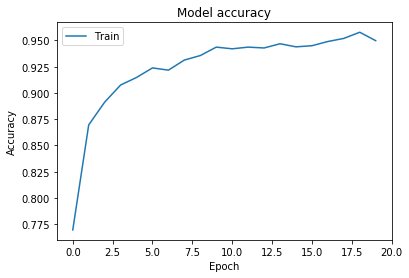

In [75]:
plt.plot(classifier.history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.xlim((-1,20))
plt.savefig('model_accuracy.png')
plt.show()


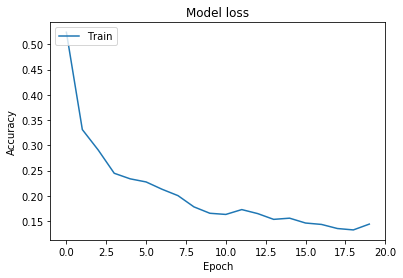

In [76]:
plt.plot(classifier.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.xlim((-1,20))
plt.savefig('model_loss.png')
plt.show()


In [56]:
#Saving the weights of the Fully Connected Neural Net
classifier.save_weights('final_weights.h5')


In [ ]:
#saving predictions
#np.savetxt('/home/cmu/AIML/Project/Final/preds_CNN_150.csv',test,delimiter=',')

In [ ]:
from keras.utils import plot_model
plot_model(classifier, to_file='model.png')